<a href="https://www.kaggle.com/code/hermengardo/ps6e2-eda-ensembling?scriptVersionId=297540981" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Imports</h1>
</div>

In [1]:
!pip install hillclimbers -q

  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import re
import seaborn as sns
import warnings
import optuna
import logging

from catboost import CatBoostClassifier
from hillclimbers import climb_hill, partial
from lightgbm import LGBMClassifier
from matplotlib.patches import Patch
from rich.console import Console
from sklearn.cluster import KMeans
from itertools import combinations, permutations
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.metrics import mean_absolute_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.base import clone
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [3]:
rc = {
    "axes.facecolor": "#fff",
    "axes.edgecolor": "#0e0e0e",
    "figure.facecolor": "#fff",
    "grid.color": "#0e0e0e",
    "axes.grid": True,
    
    "grid.linestyle":"--",
    "axes.labelcolor": "#0e0e0e",
    "xtick.color": "#0e0e0e",
    "ytick.color": "#0e0e0e",
    "legend.labelcolor": "#0e0e0e",
    "legend.edgecolor": "#fff",
    "patch.edgecolor": "#0B90A7",
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "font.size": 18,
    "font.family": "serif",
    "font.weight": "bold",
    "grid.alpha": 0.1,
}

props = {
    'boxprops': {'edgecolor': '#0e0e0e', 'alpha': 1},
    'medianprops': {'color': '#0e0e0e', 'linestyle': '-', 'linewidth': 0.7},
    'whiskerprops': {'color': '#0e0e0e', 'linestyle': '--', 'linewidth': 0.7},
    'capprops': {'color': '#0e0e0e', 'linewidth': 0.7},
    'flierprops': {'marker': 'o', 'markersize': 4, 'markerfacecolor': 'none', 'markeredgecolor': '#0e0e0e', 'markerfacecolor': '#fffdf7', 'linewidth': 0.7}
}

sns.set(rc=rc)

sns.despine()

<Figure size 640x480 with 0 Axes>

In [4]:
class settings():
    target:           str      = "Heart Disease"
    identifier:       str|None = "id"

    shuffle:          bool     = True
    splits:           int      = 15
    seed:             int      = 9182

cfg = settings()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1>✨ Loading</h1>
</div>

In [5]:
def read_data(directory:str) -> tuple:
    """
        Read CSV files from a directory and return train, test, and submission DataFrames.
    """
    data = {}
    for filename in os.listdir(directory):
        key = re.search("(.*).csv", filename).group(1)
        data[key] = pd.read_csv(
            os.path.join(
                directory, 
                filename
            )
        )
    
    train = data["train"]
    test  = data["test"]
    sub   = data["sample_submission"]
        
    return train, test, sub

In [6]:
train, test, sub = read_data("/kaggle/input/playground-series-s6e2")

train["Heart Disease"] = train["Heart Disease"].replace({
    "Presence":1,
    "Absence":0
}).astype(int).copy()

train.head()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Exploratory Data Analysis">
    ✨ EDA
  </h1>
</div>
     
* **Main takeaways:**
  1. Heart Disease is **highly correlated** with Chest pain type and Thalium.
  2. Chest pain of **type 4** is correlated with the presence of Heart Disease.
  3. Chest pain of **types 1, 2, and 3** is correlated with the absence of Heart Disease.
  4. Highly **imbalanced data** on FBS over 120 (92% of the data comes from the same category)
  6. **Older people** are more likely to have Heart Disease (no surprises, I guess)

In [7]:
def ridgeline(df, x, row, title, xlabel, pallete="viridis"):
    """
    Given a DataFrame, a target column, and a categorical variable used for
    aggregation, this function produces a kde ridgeplot.
    
    See:
    https://seaborn.pydata.org/examples/kde_ridgeplot
    """
    sns.set_theme(rc={"axes.facecolor": (0, 0, 0, 0), "axes.grid": False})
    
    g = sns.FacetGrid(df, row=row, hue=row, aspect=8, height=2, palette=pallete)
    g.map(sns.kdeplot, x, bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=2.5)
    g.map(sns.kdeplot, x, clip_on=False, color="black", lw=2.5, bw_adjust=.5)
    g.refline(y=0, linewidth=2.5, linestyle="-", color="black", clip_on=False)

    def label(x, color, label):
        plt.gca().text(0, .2, label, fontweight="bold",
                       color=color, ha="left",
                       va="center", transform=plt.gca().transAxes)

    g.map(label, x)
    g.figure.suptitle(title, fontsize=16, fontweight="bold", y=1.05)
    g.set_xlabels(xlabel)

    g.figure.subplots_adjust(hspace=-.6)
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

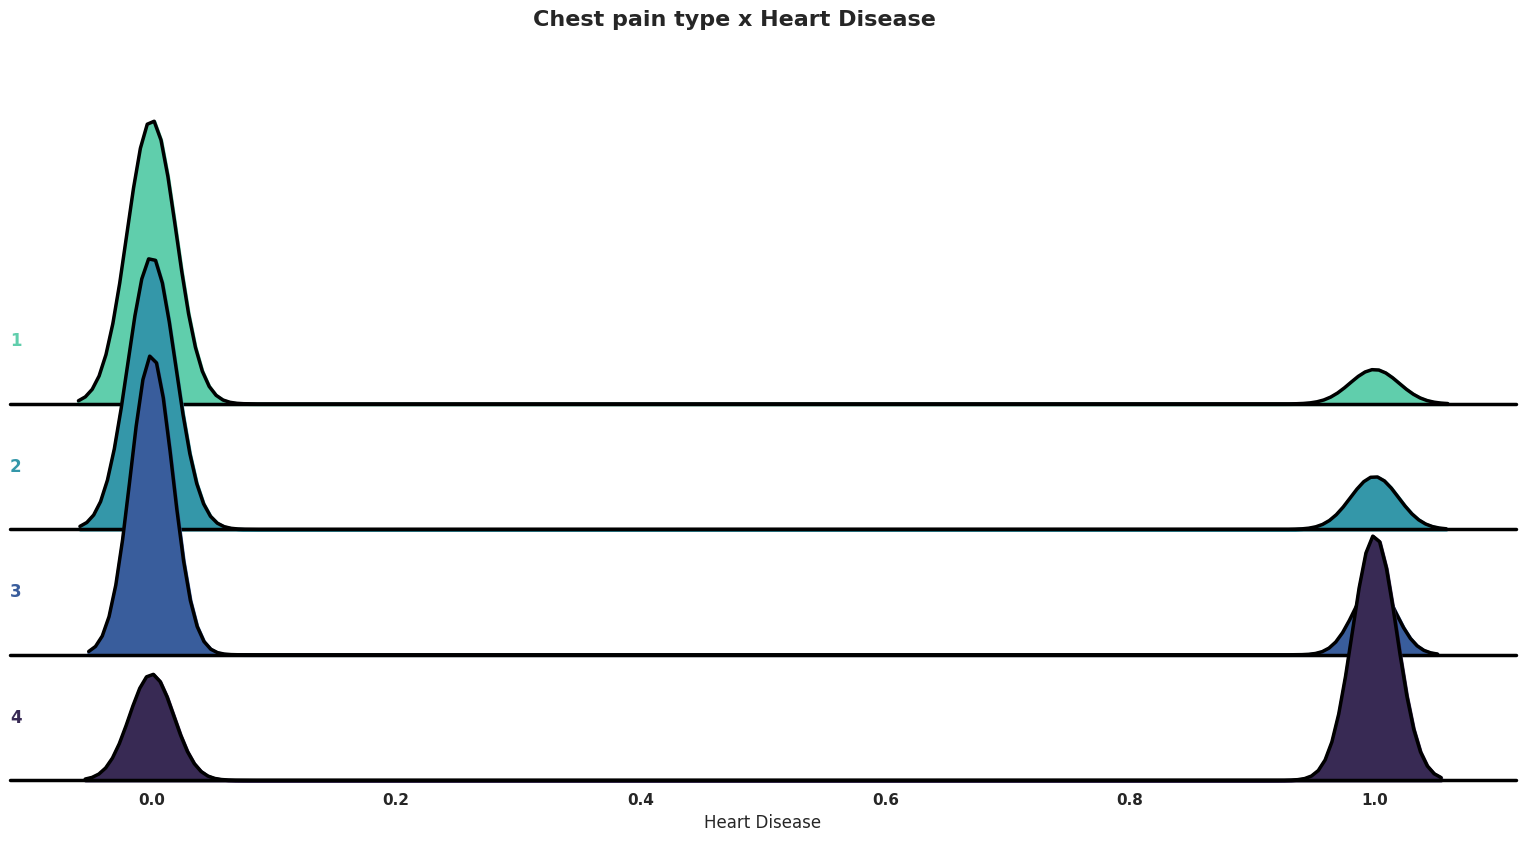

In [8]:
ridgeline(
    train,
    x="Heart Disease",
    row="Chest pain type",
    title=f"Chest pain type x Heart Disease",
    xlabel="Heart Disease",
    pallete="mako_r"
)

sns.set(rc=rc)

In [9]:
def plot_box(df, target, cols=3, colors=['#0B90A7','#E63946', '#E9C46A'], figsize=(15, 8), y_title=None, title=None, props=props):
    columns = df.select_dtypes('int').columns
    rows = np.ceil(len(columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    
    yt_labels = []
    for i, x in enumerate(columns):
        if x == target:
            continue
            
        current_ax = ax[i // cols, i % cols]
        sns.boxplot(data=df, y=target, ax=current_ax, x=x, orient='h', palette=colors, **props)
        current_ax.set_xlabel(x)
        
        if y_title and i % cols == 0:
            if len(yt_labels) == 0:
                yt_labels = [label.get_text() for label in current_ax.get_yticklabels()]
            current_ax.set_ylabel(y_title)
            current_ax.set_yticklabels(yt_labels)
        else:
            current_ax.set_ylabel('')
            current_ax.set_yticklabels('')
            
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(columns) - 1 < (rows * cols):
        for i in range(len(columns) - 1, rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Absence'),
        Patch(facecolor=colors[1], edgecolor='black', label='Presence')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .94),
        frameon=False
    )
    
    fig.tight_layout()
    plt.show()

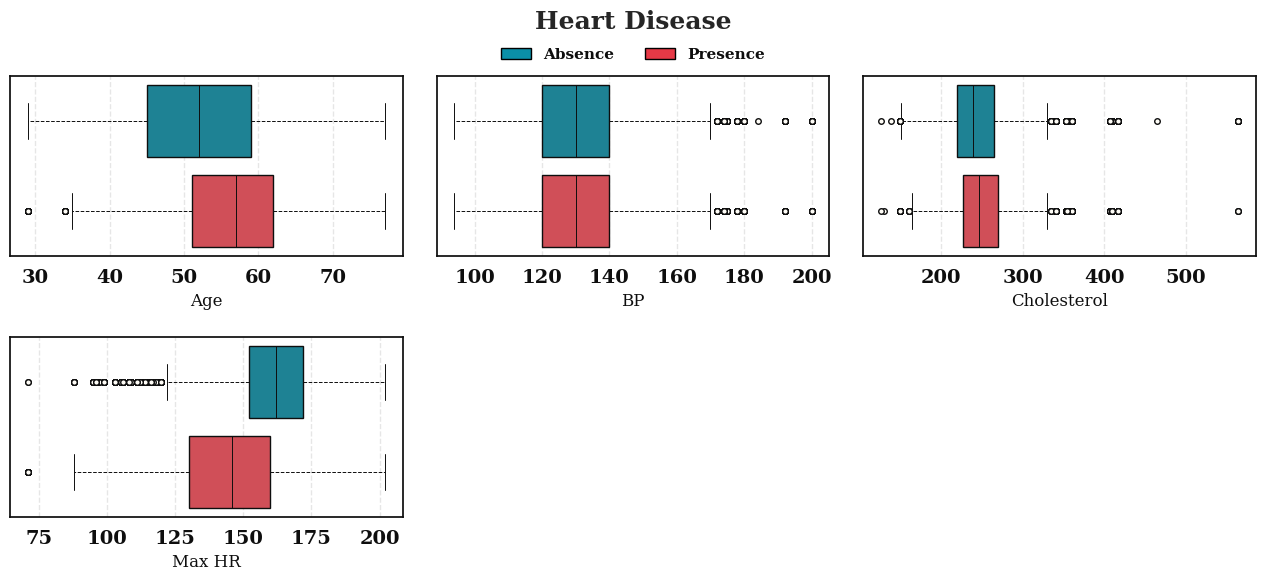

In [10]:
cat = ["id", "FBS over 120", 
       "Sex", "Chest pain type", 
       "EKG results", "Exercise angina", 
       "Slope of ST", "Number of vessels fluro", 
       "Thallium"]

plot_box(
    train.drop(cat, axis=1), 
    'Heart Disease', 
    figsize=(13, 6), 
    title='Heart Disease'
)

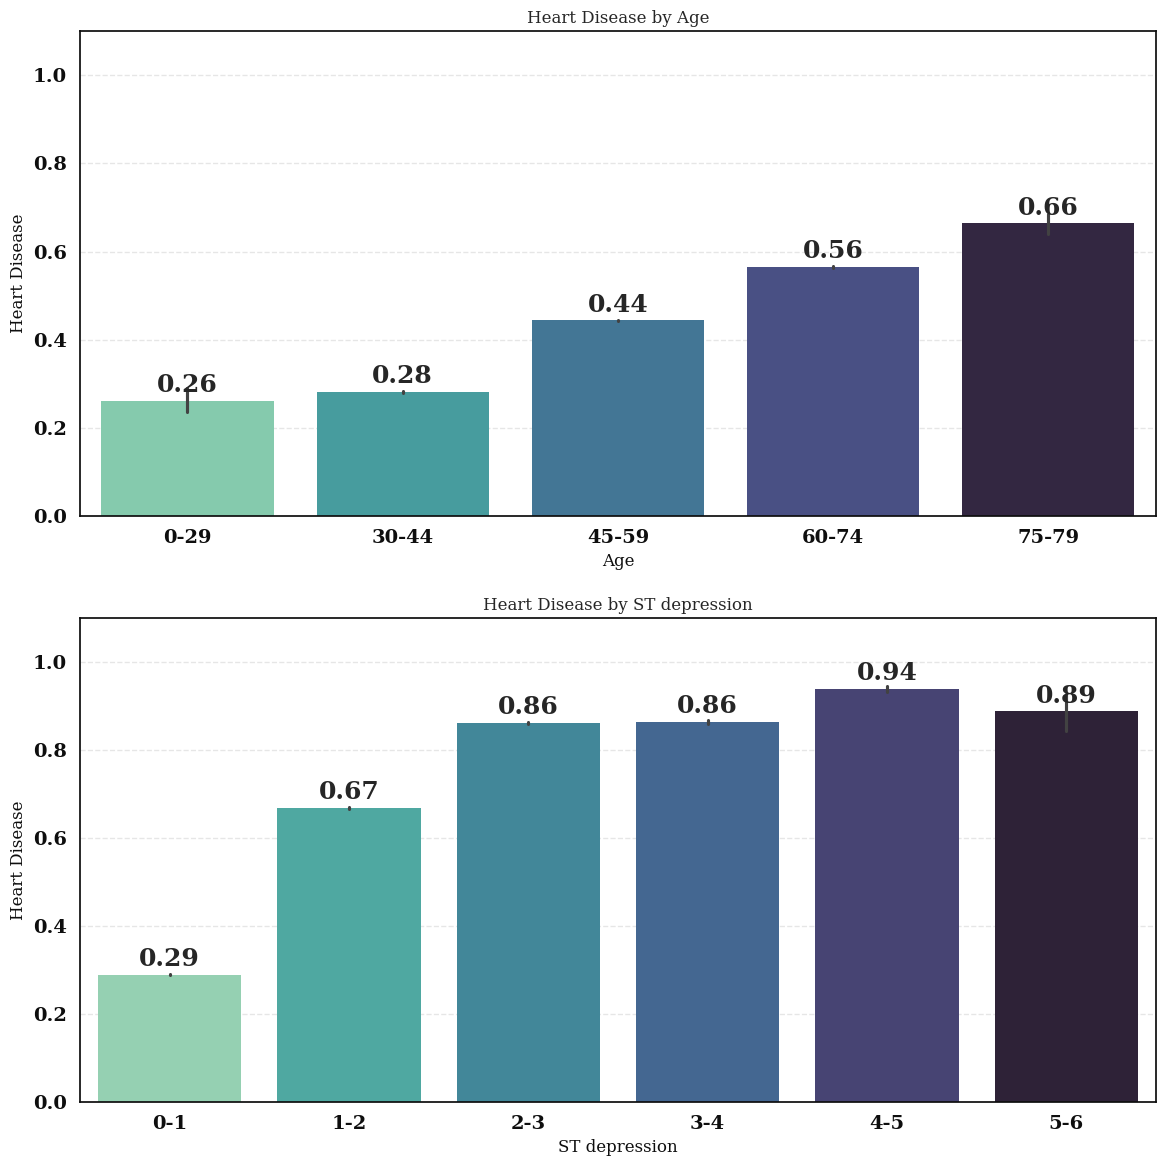

In [11]:
tmp = train.copy()

tmp['Age'] = pd.cut(tmp.Age, 
                    bins=[0, 30, 45, 60, 75, 80], 
                    labels=['0-29','30-44','45-59','60-74','75-79'], 
                    right=False)

tmp["ST depression"] = pd.cut(tmp["ST depression"], 
                    bins=[0, 1, 2, 3, 4, 5, 6], 
                    labels=['0-1','1-2','2-3','3-4','4-5', '5-6'], 
                    right=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(
    data=tmp,
    x="Age",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[0]
)

for i, v in enumerate(tmp.groupby('Age')['Heart Disease'].mean()):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[0].set_title("Heart Disease by Age")
axes[0].set_ylim(0, 1.1)

sns.barplot(
    data=tmp,
    x="ST depression",
    y="Heart Disease",
    palette="mako_r",
    edgecolor="none",
    ax=axes[1]
)

for i, v in enumerate(tmp.groupby('ST depression')['Heart Disease'].mean()):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center')

axes[1].set_title("Heart Disease by ST depression")
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

tmp = None

* **Main takeaways:**
    1. **Distributions look similar for both datasets**
    2. **Class 1 is almost nonexistent on EKG results**
    3. **Classes 2 and 3 of EKG results have similar proportions ~50/50**
    4. **ST depression with a heavy right tail, mostly because of the zeroes**

In [12]:
def plot_kde(df1:pd.DataFrame, 
             df2:pd.DataFrame, 
             cols:int = 3, 
             fill:bool = True, 
             figsize:tuple = (15, 12),
             colors:list = ["#0B90A7", "#E63946"], 
             title:str = None) -> None:

    df1 = df1.copy()
    df2 = df2.copy()

    df1.drop([cfg.identifier, cfg.target], axis=1, inplace=True)
    df2.drop([cfg.identifier], axis=1, inplace=True)
    
    numeric_columns = df1.select_dtypes(include='number').columns
    rows = np.ceil(len(numeric_columns) / cols).astype(int)

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)

    for i, x in enumerate(numeric_columns):
        current_ax = ax[i // cols, i % cols]
        sns.kdeplot(x=x,
                    color=colors[0],
                    fill=fill,
                    data=df1,
                    label='Train',
                    ax=current_ax)
        sns.kdeplot(x=x,
                    color=colors[1],
                    fill=fill,
                    data=df2,
                    label='Test',
                    ax=current_ax)
        current_ax.set_xlabel(x)
    
    if title:
        fig.suptitle(title, fontsize=18, fontweight='bold')

    if len(numeric_columns) < (rows * cols):
        for i in range(len(numeric_columns), rows * cols):
            fig.delaxes(ax.flatten()[i])

    legend_elements = [
        Patch(facecolor=colors[0], edgecolor='black', label='Train'),
        Patch(facecolor=colors[1], edgecolor='black', label='Test')
    ]

    fig.legend(
        handles=legend_elements,
        loc='upper center',
        ncol=2,
        bbox_to_anchor=(0.5, .96),
        frameon=False
    )

    fig.tight_layout()
    plt.show()

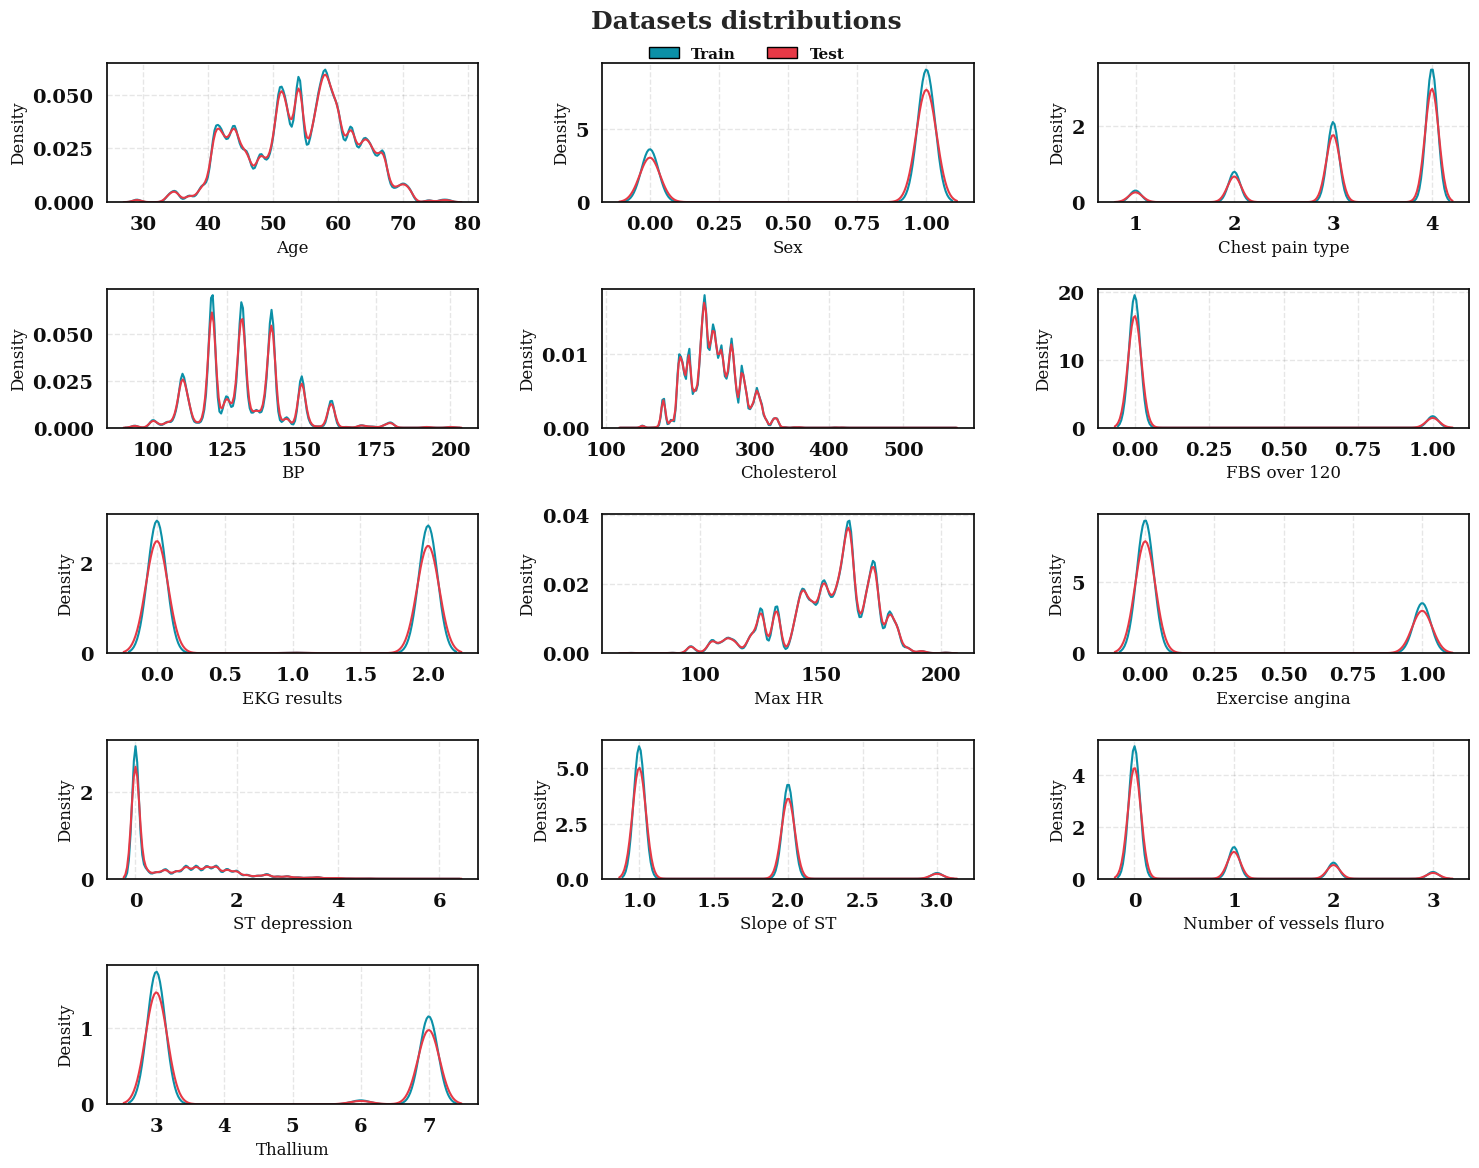

In [13]:
plot_kde(train, test, fill=False, title='Datasets distributions')

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Feature Engineering">
    ✨ Feature Engineering
  </h1>
</div>

In [14]:
X, y = train.drop(["Heart Disease", "id"], axis=1), train["Heart Disease"]

X_test = test.drop('id', axis=1)

km = KMeans(n_clusters=2, n_init='auto')
X['Cluster'] = km.fit_predict(X)

train.loc[:, 'Cluster'] = X['Cluster']
test.loc[:, 'Cluster'] = km.predict(X_test)

In [15]:
cat_cols = ["Sex", "Chest pain type", "Cluster", "FBS over 120", "EKG results", "Exercise angina", "Slope of ST", "Number of vessels fluro", "Thallium"]
num_cols = ["Age", "BP", "Cholesterol", "Max HR", "ST depression"]

In [16]:
def feature_engineering(data, num_cols, cat_cols):
    console = Console()
    initial_feature_count = data.shape[1]
    
    data = data.copy()

    for col in tqdm(cat_cols):
        agg = (
            data.groupby(col)[num_cols]
            .agg(["min", "max", "mean", "sum"])
            .reset_index()
        )
        
        agg.columns = [
            f"{col}_" + "_".join(c).strip("_") if c[0] != col else col
            for c in agg.columns.values
        ]
        
        data = data.merge(agg, on=col)

    for col in tqdm(num_cols):
        data[f"{col}_log"] = np.log1p(data[col])
        data[f"{col}_sqrt"] = np.sqrt(data[col])

    for col1, col2 in tqdm(list(combinations(num_cols, 2))):
        data[f"{col1}+{col2}"] = data[col1] + data[col2]
        data[f"{col1}*{col2}"] = data[col1] * data[col2]

    for col1, col2 in tqdm(list(permutations(num_cols, 2))):
        data[f"{col1}-{col2}"] = data[col1] - data[col2]
        data[f"{col1}/{col2}"] = (data[col1] + 1) / (data[col2] + 1) # all values are >= 0

    console.print(f"Added {data.shape[1] - initial_feature_count} features", style="bold green")
    
    return data.copy()

In [17]:
def remove_high_correlated(data, corr_threshold=0.95):
    data = data.copy()
    console = Console()
    
    corr = data.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        
    to_drop = [
        column for column in upper.columns
        if any(upper[column] > corr_threshold)
    ]
    
    console.print(f"Highly Correlated: {len(to_drop)}", style="bold red")
    
    return to_drop

In [18]:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

train = feature_engineering(train, num_cols, cat_cols)
test = feature_engineering(test, num_cols, cat_cols)

to_drop = remove_high_correlated(train.drop("Heart Disease", axis=1))

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

100%|██████████| 20/20 [00:00<00:00, 87.61it/s]


Added 250 features

100%|██████████| 20/20 [00:00<00:00, 248.97it/s]


Added 250 features

Highly Correlated: 147

In [19]:
X, y = train.drop(["Heart Disease"], axis=1), train["Heart Disease"]
X_test = test

In [20]:
def feature_selection(X, y, clf, cv, seed=42, tolerance=0.0001):

    X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    remaining = list(X_dev.columns)
    selected = []
    best_score = 0.0

    console = Console()

    while remaining:
        scores = []

        for feature in remaining:
            current = selected + [feature]
            roc = []

            for train_idx, val_idx in cv.split(X_dev, y_dev):
                X_train = X_dev[current].iloc[train_idx]
                X_val = X_dev[current].iloc[val_idx]
                y_train = y_dev.iloc[train_idx]
                y_val = y_dev.iloc[val_idx]

                model = clone(clf)
                model.fit(X_train, y_train)

                probs = model.predict_proba(X_val)[:, 1]
                roc.append(roc_auc_score(y_val, probs))

            scores.append((feature, np.mean(roc)))

        best_feature, best_feature_score = max(scores, key=lambda x: x[1])

        if best_feature_score > best_score + tolerance:
            selected.append(best_feature)
            remaining.remove(best_feature)
            best_score = best_feature_score
            console.print(f"Keeping {best_feature} | {best_feature_score:.4f}", style="bold green")
        else:
            break

    final_model = clone(clf)
    final_model.fit(X_dev[selected], y_dev)

    test_probs = final_model.predict_proba(X_test[selected])[:, 1]
    final_test_score = roc_auc_score(y_test, test_probs)

    console.print(f"\nFinal Test Score: {final_test_score:.4f}")

    return selected

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=cfg.shuffle, random_state=cfg.seed)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        penalty="l2",
        solver="liblinear",
        random_state=cfg.seed,
        max_iter=500
    ))
])

selected_cols = feature_selection(X, y, clf, skf)

Keeping Thallium | 0.8010

Keeping Age-Max HR | 0.8849

Keeping Chest pain type_Age_mean | 0.9200

Keeping Number of vessels fluro_Age_mean | 0.9329

Keeping ST depression | 0.9408

Keeping Exercise angina | 0.9457

Keeping Sex | 0.9492

Keeping Slope of ST | 0.9518

Keeping EKG results | 0.9525

Keeping Slope of ST_Age_sum | 0.9527

Keeping Cholesterol/ST depression | 0.9528

Final Test Score: 0.9525

In [22]:
X, y = train.loc[:, selected_cols], train["Heart Disease"]
test = test.loc[:, selected_cols]

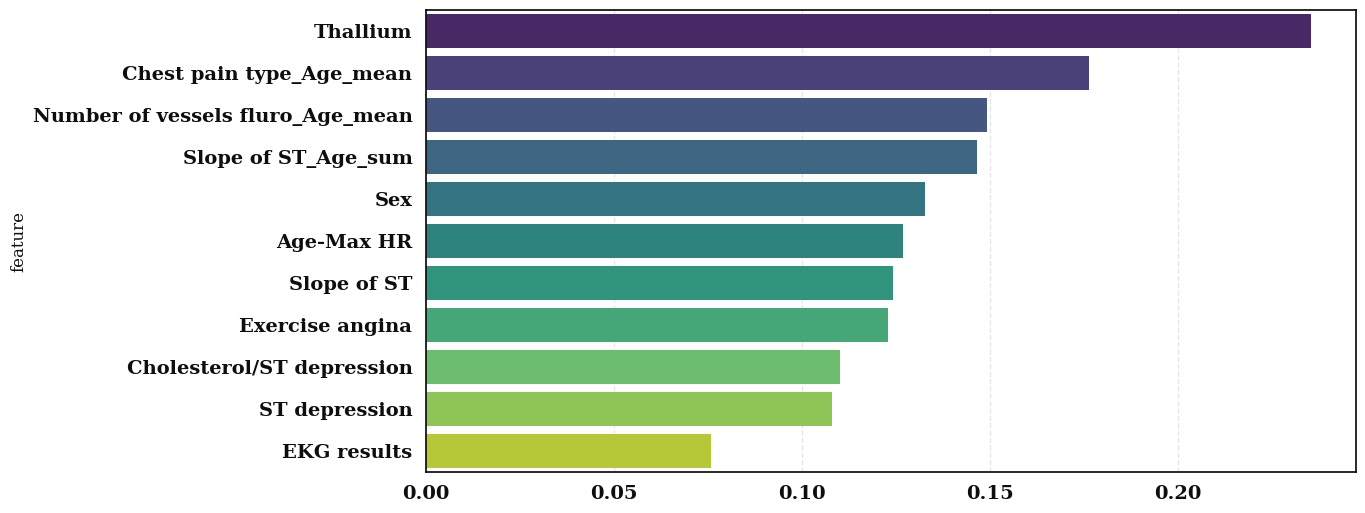

In [23]:
mic = mutual_info_classif(X, y)

mi = pd.DataFrame(
    {"feature": X.columns, 
     "Mutual Information": mic}
).set_index("feature")["Mutual Information"].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=mi.values, 
    y=mi.index,
    orient="h",
    palette="viridis",
    edgecolor="none",
    linewidth=0
)

plt.show()

<div style="font-family: serif; font-weight: bold; text-align: center;">
  <h1 id="Model">
    ✨ Model
  </h1>
</div>

In [24]:
console = Console()

class Processor:
    def __init__(self, X, y, test, models):
        self.oof_train = pd.DataFrame()
        self.oof_test = pd.DataFrame()
        self.val_scores = pd.DataFrame()
        
        self.X = X
        self.y = y
        self.test = test
        self.models = models

        self.cv = StratifiedKFold(
            n_splits=cfg.splits, 
            shuffle=cfg.shuffle, 
            random_state=cfg.seed
        )
        
    def process(self):
        for name, model in self.models:
            console.print(f"\n[bold blue]Model:[/bold blue] [cyan]{name}[/cyan]")
            self.cross_val_score(name, model)
            console.print(f"[bold green]Finished {name}[/bold green]\n" + "—" * 40)
    
    def cross_val_score(self, name, model):
        oof_tr = np.zeros(self.X.shape[0])
        oof_tt = np.zeros(self.test.shape[0])
        scores = []
        
        
        for fold, (train_idx, val_idx) in enumerate(self.cv.split(self.X, self.y)):
            X_tr, y_tr = self.X.iloc[train_idx], self.y.iloc[train_idx]
            X_val, y_val = self.X.iloc[val_idx], self.y.iloc[val_idx]
            
            model.fit(X_tr, y_tr)
            
            probs_val = model.predict_proba(X_val)[:, 1]
            oof_tr[val_idx] = probs_val
            oof_tt += model.predict_proba(self.test)[:, 1] / cfg.splits
            
            fold_score = roc_auc_score(y_val, probs_val)
            scores.append(fold_score)
            
            console.print(f"[dim]Fold {fold+1}: {fold_score:.4f}[/dim]")
            
        self.oof_train[name] = oof_tr
        self.oof_test[name] = oof_tt
        self.val_scores[name] = scores
        
        console.print(f"[bold orange]>>> {name} AUC: {np.mean(scores):.5f} ± {np.std(scores):.5f}[/bold orange]\n")

In [25]:
models = [
    ('hgb', Pipeline([
        ('model', HistGradientBoostingClassifier(
            **{'random_state':cfg.seed, 
               'max_iter': 615, 
               'max_depth': 15, 
               'learning_rate': 0.0849421325741134, 
               'l2_regularization': 0.26610703720676765, 
               'min_samples_leaf': 9, 
               'max_bins': 191}))
        ])
    ),
    (
        "LGBM",
        Pipeline([
            ("model", LGBMClassifier(
                objective="binary",
                metric="auc",
                verbosity=-1,
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "XGBoost",
        Pipeline([
            ("model", XGBClassifier(
                objective="binary:logistic",
                eval_metric="auc",
                verbosity=0,
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    ),
    (
        "CatBoost",
        Pipeline([
            ("model", CatBoostClassifier(
                objective="Logloss",
                eval_metric="AUC",
                verbose=0,
                random_state=cfg.seed,
            ))
        ])
    ),
    (
        "Logistic",
        Pipeline([
            ("scaler", StandardScaler()),
            ("model", LogisticRegression(
                random_state=cfg.seed,
                n_jobs=-1
            ))
        ])
    )
]

In [26]:
stack = Processor(X, y, test, models)
stack.process()

Model: hgb

Fold 1: 0.9512

Fold 2: 0.9546

Fold 3: 0.9537

Fold 4: 0.9533

Fold 5: 0.9532

Fold 6: 0.9519

Fold 7: 0.9522

Fold 8: 0.9533

Fold 9: 0.9546

Fold 10: 0.9521

Fold 11: 0.9533

Fold 12: 0.9538

Fold 13: 0.9525

Fold 14: 0.9544

Fold 15: 0.9533

>>> hgb AUC: 0.95317 ± 0.00096

Finished hgb
————————————————————————————————————————

Model: LGBM

Fold 1: 0.9512

Fold 2: 0.9546

Fold 3: 0.9536

Fold 4: 0.9534

Fold 5: 0.9532

Fold 6: 0.9519

Fold 7: 0.9522

Fold 8: 0.9533

Fold 9: 0.9546

Fold 10: 0.9522

Fold 11: 0.9533

Fold 12: 0.9537

Fold 13: 0.9524

Fold 14: 0.9544

Fold 15: 0.9533

>>> LGBM AUC: 0.95316 ± 0.00096

Finished LGBM
————————————————————————————————————————

Model: XGBoost

Fold 1: 0.9510

Fold 2: 0.9542

Fold 3: 0.9532

Fold 4: 0.9532

Fold 5: 0.9529

Fold 6: 0.9516

Fold 7: 0.9520

Fold 8: 0.9529

Fold 9: 0.9543

Fold 10: 0.9518

Fold 11: 0.9528

Fold 12: 0.9533

Fold 13: 0.9523

Fold 14: 0.9540

Fold 15: 0.9531

>>> XGBoost AUC: 0.95284 ± 0.00093

Finished XGBoost
————————————————————————————————————————

Model: CatBoost

Fold 1: 0.9511

Fold 2: 0.9545

Fold 3: 0.9534

Fold 4: 0.9533

Fold 5: 0.9531

Fold 6: 0.9518

Fold 7: 0.9522

Fold 8: 0.9532

Fold 9: 0.9544

Fold 10: 0.9520

Fold 11: 0.9532

Fold 12: 0.9537

Fold 13: 0.9525

Fold 14: 0.9542

Fold 15: 0.9533

>>> CatBoost AUC: 0.95306 ± 0.00096

Finished CatBoost
————————————————————————————————————————

Model: Logistic

Fold 1: 0.9510

Fold 2: 0.9542

Fold 3: 0.9533

Fold 4: 0.9530

Fold 5: 0.9530

Fold 6: 0.9514

Fold 7: 0.9519

Fold 8: 0.9528

Fold 9: 0.9543

Fold 10: 0.9518

Fold 11: 0.9527

Fold 12: 0.9532

Fold 13: 0.9519

Fold 14: 0.9538

Fold 15: 0.9527

>>> Logistic AUC: 0.95274 ± 0.00095

Finished Logistic
————————————————————————————————————————

In [27]:
oof_train = stack.oof_train.copy()
oof_test = stack.oof_test.copy()

In [28]:
# Checkout: https://github.com/Matt-OP/hillclimbers
# and https://www.kaggle.com/competitions/playground-series-s3e14/writeups/matt-op-4th-place-solution-introducing-hillclimber
final_test_preds = climb_hill(
    train=train,
    oof_pred_df=oof_train,
    test_pred_df=oof_test,
    target="Heart Disease",
    objective="maximize",
    
    eval_metric=partial(roc_auc_score),
    precision=0.001,
    plot_hill=False,
    return_oof_preds=False
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

hgb:      0.95316 (best solo model)
LGBM:     0.95316
CatBoost: 0.95306
XGBoost:  0.95284
Logistic: 0.95274

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: CatBoost | Best weight: 0.421 | Best roc_auc_score: 0.95328
Iteration: 2 | Model added: Logistic | Best weight: 0.225 | Best roc_auc_score: 0.95334
Iteration: 3 | Model added: XGBoost | Best weight: 0.067 | Best roc_auc_score: 0.95334
Iteration: 4 | Model added: LGBM | Best weight: 0.064 | Best roc_auc_score: 0.95334


In [29]:
sub["Heart Disease"] = final_test_preds

sub.to_csv('submission.csv', index=False)

In [30]:
sub.head()

,id,Heart Disease
0,630000,0.874395
1,630001,0.007269
2,630002,0.984489
3,630003,0.004567
4,630004,0.263591
